In [38]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [55]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "titel" 
FROM scraper_auto  
WHERE prijs < 15000 AND prijs > 900 AND bron='marktplaats'
''', conn)
df = df_raw.dropna()
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,2007.714612,174580.257991,80.305936,2712.755708,0.961187,0.760274
std,1.774035,57862.200953,13.282273,933.715855,0.193369,0.427404
min,2005.000000,15570.000000,51.000000,944.000000,0.000000,0.000000
25%,2006.000000,133135.750000,75.000000,1995.000000,1.000000,1.000000
50%,2007.000000,175705.000000,78.000000,2670.000000,1.000000,1.000000
75%,2009.000000,207475.000000,84.000000,3250.000000,1.000000,1.000000
max,2014.000000,368884.000000,155.000000,6950.000000,1.000000,1.000000


In [56]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,titel
94,2010,174637.0,84,1.0,0,Fiat Grande Punto 1.3 MJet Actual NIEUWE APK A...
306,2011,194984.0,84,1.0,0,Fiat Grande Punto 1.3 MJet Actual Airco3drsapk...
92,2007,70185.0,65,1.0,1,Fiat Grande Punto 1.2 Active
221,2010,177079.0,65,1.0,1,Fiat Grande Punto 1.2 Actual Met Airco
292,2006,146535.0,77,1.0,1,Fiat Grande Punto 1.4 8v Edizione Blue & Me / ...
...,...,...,...,...,...,...
319,2011,145139.0,84,1.0,0,Fiat Grande Punto 1.3 MJet Actual
291,2008,131186.0,78,1.0,1,Fiat Grande Punto 1.4 Dynamic Airco 5DRS
183,2006,270006.0,95,1.0,1,Fiat Grande Punto 1.416V Sport bouwjaar 2006 m...
348,2008,138034.0,77,1.0,1,"Fiat Grande Punto 1.4 Dynamic, Sportieve Black..."


In [57]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
        ('text',  CountVectorizer(), 'titel')
    ],
    remainder='passthrough')

In [58]:
pipelines = []
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('LR', DecisionTreeRegressor())])))
pipelines.append(('Lasso                      ', Pipeline([('preprocessor', preprocessor),('LASSO', Lasso())])))
pipelines.append(('ElasticNet                 ', Pipeline([('preprocessor', preprocessor),('EN', ElasticNet())])))
pipelines.append(('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('KNN', KNeighborsRegressor())])))
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('CART', DecisionTreeRegressor())])))
pipelines.append(('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %i (%i)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

DecisionTreeRegressor      : 588 (76)
Lasso                      : 441 (48)
ElasticNet                 : 479 (75)
KNeighborsRegressor        : 508 (74)
DecisionTreeRegressor      : 605 (81)
GradientBoostingRegressor  : 426 (55)


In [59]:
param_grid = {
    'preprocessor__numeric__imputer__strategy': ['mean', 'median', 'constant'],
    'preprocessor__text__ngram_range': [(1,1), (1,2), (1,3)],
#     'classifier__loss': ['ls', 'lad', 'huber', 'quantile'],
#     'classifier__learning_rate': np.arange(0, 0.5, 0.1)
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(loss='huber', learning_rate=0.1))
])

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 383.550


{'preprocessor__numeric__imputer__strategy': 'median',
 'preprocessor__text__ngram_range': (1, 1)}

In [60]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 383
Mean squared error:	 222587


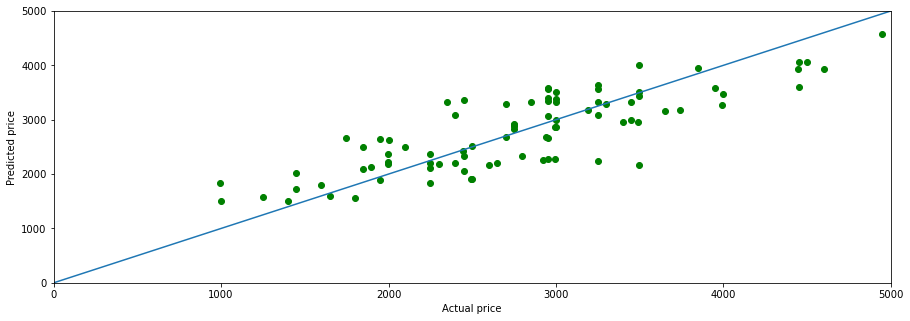

In [61]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.plot([0,5000], [0,5000])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [62]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']